# In this notebook, I'll train a reward model with some systematic noise added and see how this affects the interpretability of the reward model

In [1]:
import os
import sys
import importlib
from pathlib import Path
from itertools import product, islice
import h5py
import random

from tqdm.auto import tqdm

import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.transform
import torch as th
import torch.nn as nn

from tqdm.auto import tqdm

from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import VecEnvWrapper, VecEnv, DummyVecEnv
from stable_baselines3.common.vec_env import VecTransposeImage

sys.path.insert(1, "../rl-baselines3-zoo")
import utils.import_envs  # noqa: F401 pylint: disable=unused-import
from utils.utils import StoreDict
from utils import ALGOS, create_test_env, get_latest_run_id, get_saved_hyperparams

In [2]:
########### Set Device ############
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
dtype = th.float32
th.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cuda


In [3]:
env_id = "BreakoutNoFrameskip-v4"
folder = "../agents"
algo = "a2c"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 3
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [4]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

Stacking 4 frames


In [5]:
class RewardData(th.utils.data.Dataset):
    def __init__(self, train=True):
        self.f = h5py.File(f"../datasets/rewards_{env_id}.hdf5", 'r')
        if train:
            self.group = self.f['train']
        else:
            self.group = self.f['test']
    
    def __getitem__(self, k):
        if k % 2 == 0:
            input = self.group['zeros-inputs'][k // 2]
            label = self.group['zeros-labels'][k // 2]
            return (input, label)
        else:
            input = self.group['ones-inputs'][k // 2]
            label = self.group['ones-labels'][k // 2]
            return (input, label)
    
    def __len__(self):
        return self.group['ones-labels'].shape[0] + self.group['zeros-labels'].shape[0]
    
    def close(self):
        self.f.close()
        
class RewardModel(nn.Module):
    """A reward model using an A2C feature extractor"""
    def __init__(self, env, device):
        super(RewardModel, self).__init__()
        self.ac_model = ALGOS['a2c']('CnnPolicy', env).policy
        self.reward_net = nn.Linear(512, 1).to(device)
        self.device = device
    
    def forward(self, obs):
        obs_transposed = VecTransposeImage.transpose_image(obs)
        latent, _, _= self.ac_model._get_latent(th.tensor(obs_transposed).to(self.device))
        return self.reward_net(latent)
    
    def freeze_extractor(self):
        for p in self.ac_model.policy.features_extractor.parameters():
            p.requires_grad = False

In [6]:
def create_circular_mask(h, w, center, radius=5):
#     Y, X = np.ogrid[:h, :w]
#     dist_from_center = np.sqrt((X - center[1])**2 + (Y-center[0])**2)
#     mask = dist_from_center <= radius
    mask = np.zeros((h, w))
    y, x = center
    mask[y-radius//5:y+radius//2, x-radius//2:x+radius//2] = 1.0
    return np.array(mask, dtype=np.float32)

def max_k(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return items

def max_k_and_values(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return list(zip(items, values))

loss_fn = th.nn.MSELoss()
def policy_saliency(model, obs, loc, radius=5, device='cuda'):
    obs_transposed = VecTransposeImage.transpose_image(np.copy(obs))
    latent, _, _ = model.policy._get_latent(th.from_numpy(obs_transposed).to(device))
    baseline = model.policy.action_net(latent)
    M = create_circular_mask(84, 84, center=loc, radius=radius)
    for k in range(4):
        img = obs_transposed[0, k, :, :]
        A = scipy.ndimage.gaussian_filter(img, 3)
        obs_transposed[0, k, :, :] = img*(1 - M) + A*M
    latent, _, _ = model.policy._get_latent(th.from_numpy(obs_transposed).to(device))
    modified = model.policy.action_net(latent)
    return loss_fn(baseline, modified).item()

def value_saliency(model, obs, loc, radius=5, device='cuda'):
    obs_transposed = VecTransposeImage.transpose_image(np.copy(obs))
    latent, _, _ = model.policy._get_latent(th.from_numpy(obs_transposed).to(device))
    baseline = model.policy.value_net(latent)
    M = create_circular_mask(84, 84, center=loc, radius=radius)
    for k in range(4):
        img = obs_transposed[0, k, :, :]
        A = scipy.ndimage.gaussian_filter(img, 3)
        obs_transposed[0, k, :, :] = img*(1 - M) + A*M
    latent, _, _ = model.policy._get_latent(th.from_numpy(obs_transposed).to(device))
    modified = model.policy.value_net(latent)
    return loss_fn(baseline, modified).item()

def reward_model_saliency(model: RewardModel, obs, loc, radius=5, device='cuda'):
    obs_copy = np.copy(obs)
    baseline = model(obs_copy)
    M = create_circular_mask(84, 84, center=loc, radius=radius)
    for k in range(4):
        img = obs_copy[0, :, :, k]
        A = scipy.ndimage.gaussian_filter(img, 3)
        obs_copy[0, :, :, k] = img*(1 - M) + A*M
    modified = model(obs_copy)
    return loss_fn(baseline, modified).item()

def invert_preprocessing(loc):
    x, y = loc
    return (int(210/84*x), int(160/84*y))

In [7]:
obs = env.reset()
for i in range(300):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if done:
        break

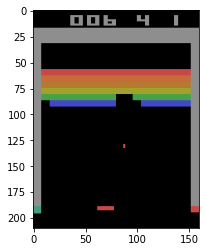

In [8]:
plt.imshow(env.get_images()[0])

## Create randomly-initialized reward model, sample its mean and std, and define reshaping function so that the model outputs values with mean 0 and std 1. (technically, the model does not output this, but we define a function ot transform its output to have these statistics)

In [9]:
train = RewardData(train=True)
test = RewardData(train=False)

train_loader = th.utils.data.DataLoader(train, batch_size=20, shuffle=True, num_workers=0)
test_loader = th.utils.data.DataLoader(test, batch_size=20, shuffle=False, num_workers=0)

In [28]:
for alpha in [0.2, 0.4, 1.5]:
    
    rm_noise = RewardModel(env, device) # define noisy network
    
    predicted_rewards = []
    obs = env.reset()
    for i in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        predicted_rewards.append(rm_noise(obs).item())
        if done:
            break
    predicted_rewards = np.array(predicted_rewards)

    m, s = predicted_rewards.mean(), predicted_rewards.std()

    def shaped(x):
        return (x - m) * 1/s
    
    rm = RewardModel(env, device) # define the real reward network
    loss_fn = th.nn.MSELoss()
    optimizer = th.optim.Adam(rm.parameters())
    
    for epoch in range(2):
        for samples, targets in tqdm(train_loader):
            optimizer.zero_grad()
            batch_loss = loss_fn(rm(samples), targets.to(device))
            batch_loss.backward()
            optimizer.step()
            
    outof = 0
    testing_loss = 0
    with th.no_grad():
        for samples, target in islice(test_loader, 500):
            testing_loss += loss_fn(rm(samples), targets.to(device))
            outof += len(target)
    testing_loss = float(testing_loss / outof)
    print("Loss after training without noise: {}".format(testing_loss))
    
    for epoch in tqdm(range(3)):
        for samples, targets in islice(train_loader, 500):
            optimizer.zero_grad()
            noise = shaped(rm_noise(samples))
            targets = targets.to(device) + alpha*noise
            batch_loss = loss_fn(rm(samples), targets.to(device))
            batch_loss.backward()
            optimizer.step()
        outof = 0
        testing_loss = 0
        with th.no_grad():
            for samples, target in islice(train_loader, 500):
                testing_loss += loss_fn(rm(samples), targets.to(device))
                outof += len(target)
        testing_loss = float(testing_loss / outof)
        print("Alpha: {} | Testing Loss: {:.5f}".format(alpha, testing_loss))
    th.save(rm.state_dict(), f"../reward-models/breakout_rm_alpha{alpha}.pt")
    

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Loss after training without noise: 0.029149910435080528


Alpha: 0.2 | Testing Loss: 0.05681
Alpha: 0.2 | Testing Loss: 0.06827
Alpha: 0.2 | Testing Loss: 0.06480




Loss after training without noise: 0.028051171451807022


Alpha: 0.4 | Testing Loss: 0.05925
Alpha: 0.4 | Testing Loss: 0.07892
Alpha: 0.4 | Testing Loss: 0.06602




Loss after training without noise: 0.02800794690847397


Alpha: 1.5 | Testing Loss: 3.56912
Alpha: 1.5 | Testing Loss: 3.16158
Alpha: 1.5 | Testing Loss: 3.19640



In [34]:
rm = RewardModel(env, device)
rm.load_state_dict(th.load("../reward-models/breakout_rm_alpha1.5.pt"))

<All keys matched successfully>

In [36]:
obs = env.reset()
for i in range(50):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if done:
        break
    print("True: {:.3f} | Predicted: {:.3f}".format(reward[0], rm(obs).item()))
        

True: 0.000 | Predicted: 6.337
True: 0.000 | Predicted: -5.484
True: 0.000 | Predicted: -3.327
True: 0.000 | Predicted: -2.755
True: 0.000 | Predicted: -2.607
True: 0.000 | Predicted: -2.871
True: 0.000 | Predicted: -2.454
True: 0.000 | Predicted: -3.220
True: 0.000 | Predicted: -3.348
True: 0.000 | Predicted: -2.608
True: 0.000 | Predicted: -3.173
True: 0.000 | Predicted: -2.647
True: 0.000 | Predicted: -2.725
True: 0.000 | Predicted: -3.206
True: 0.000 | Predicted: -2.927
True: 0.000 | Predicted: -2.421
True: 0.000 | Predicted: -2.130
True: 0.000 | Predicted: -2.350
True: 0.000 | Predicted: -2.754
True: 0.000 | Predicted: -3.138
True: 0.000 | Predicted: -2.791
True: 0.000 | Predicted: -3.088
True: 0.000 | Predicted: -2.550
True: 0.000 | Predicted: -1.992
True: 0.000 | Predicted: -2.396
True: 0.000 | Predicted: -1.906
True: 1.000 | Predicted: -2.359
True: 0.000 | Predicted: -1.958
True: 0.000 | Predicted: -2.119
True: 0.000 | Predicted: -3.032
True: 0.000 | Predicted: -2.696
True: 0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


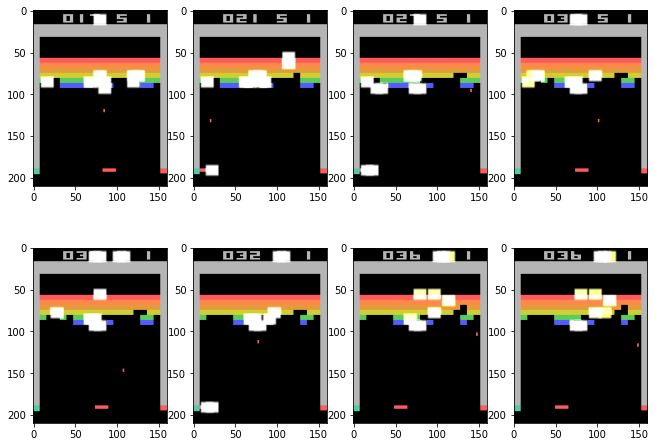

In [38]:
plt.figure(figsize=(11, 8))

radius = 8
stride = 3
k = 0
N = 8

obs = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if random.randint(0, 50) == 0:
        plt.subplot(2, N//2, k+1)
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm, obs, e, radius=radius))
        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()
        # max_value = pairs[0][1]
        heatmap = np.zeros((210, 160, 3))
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            heatmap = spot + (1-spot)*heatmap
        #     screenshot = screenshot / screenshot.max()
        #     screenshot[:, :, 2] += region * a
        screenshot = screenshot + heatmap
        plt.imshow(screenshot)
        k += 1
    if k == N:
        break

In [11]:
matplotlib.use("Agg")
import matplotlib.animation as manimation

# The order is:

#1 = most noise
#2 = no noise
#3 = some noise

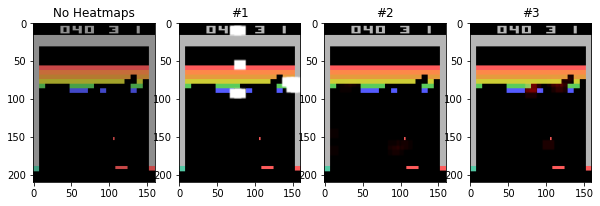

In [44]:
alphas = [0.4, 1.5]

radius = 8
stride = 3

TIMESTEPS = 30

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Can you tell which is best?", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=14, metadata=metadata)

fig, (axes) = plt.subplots(1, 4, gridspec_kw={'width_ratios': [1, 1, 1, 1]}, figsize=(10, 5))
axes[0].set_title("No Heatmaps")
for k in range(1, 4):
    axes[k].set_title(f"#{k}")
frames = [ax.imshow(env.get_images()[0]) for ax in axes]

models = []

rm = RewardModel(env, device)
rm.load_state_dict(th.load(f"../reward-models/breakout_rm_alpha1.5.pt"))
models.append(rm)

rm = RewardModel(env, device)
rm.load_state_dict(th.load(f"../reward-models/breakout_rm_v1.pt"))
models.append(rm)

rm = RewardModel(env, device)
rm.load_state_dict(th.load(f"../reward-models/breakout_rm_alpha0.4.pt"))
models.append(rm)

obs = env.reset()
with writer.saving(fig, "../videos/breakout/comparing_reward_models.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        for k in range(3):
            pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(models[k], obs, e, radius=radius))
            screenshot = env.get_images()[0]
            screenshot = screenshot / screenshot.max()
#             max_value = pairs[0][1]
#             max_saliencies.append(max_value)
            for loc, value in pairs:
                r, g, b, a = matplotlib.cm.hot(value)
                region = create_circular_mask(84, 84, center=loc, radius=radius)
                region = skimage.transform.resize(region, (210, 160))
                spot = np.zeros((210, 160, 3))
                spot[:, :, 0] = r * region
                spot[:, :, 1] = g * region
                spot[:, :, 2] = b * region
                spot = spot * a
                screenshot = spot + (1-spot)*screenshot
                screenshot = screenshot / screenshot.max()
            frames[k+1].set_data(screenshot)
        frames[0].set_data(env.get_images()[0])
        writer.grab_frame()
#         plt.subplots_adjust(wspace=0.2)

# Eh 0.4 isn't enough. Let's do 0.6 now

In [45]:
for alpha in [0.6]:
    
    rm_noise = RewardModel(env, device) # define noisy network
    
    predicted_rewards = []
    obs = env.reset()
    for i in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        predicted_rewards.append(rm_noise(obs).item())
        if done:
            break
    predicted_rewards = np.array(predicted_rewards)

    m, s = predicted_rewards.mean(), predicted_rewards.std()

    def shaped(x):
        return (x - m) * 1/s
    
    rm = RewardModel(env, device) # define the real reward network
    loss_fn = th.nn.MSELoss()
    optimizer = th.optim.Adam(rm.parameters())
    
    for epoch in range(2):
        for samples, targets in tqdm(train_loader):
            optimizer.zero_grad()
            batch_loss = loss_fn(rm(samples), targets.to(device))
            batch_loss.backward()
            optimizer.step()
            
    outof = 0
    testing_loss = 0
    with th.no_grad():
        for samples, target in islice(test_loader, 500):
            testing_loss += loss_fn(rm(samples), targets.to(device))
            outof += len(target)
    testing_loss = float(testing_loss / outof)
    print("Loss after training without noise: {}".format(testing_loss))
    
    for epoch in tqdm(range(3)):
        for samples, targets in islice(train_loader, 500):
            optimizer.zero_grad()
            noise = shaped(rm_noise(samples))
            targets = targets.to(device) + alpha*noise
            batch_loss = loss_fn(rm(samples), targets.to(device))
            batch_loss.backward()
            optimizer.step()
        outof = 0
        testing_loss = 0
        with th.no_grad():
            for samples, target in islice(train_loader, 500):
                testing_loss += loss_fn(rm(samples), targets.to(device))
                outof += len(target)
        testing_loss = float(testing_loss / outof)
        print("Alpha: {} | Testing Loss: {:.5f}".format(alpha, testing_loss))
    th.save(rm.state_dict(), f"../reward-models/breakout_rm_alpha{alpha}.pt")
    

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Loss after training without noise: 0.035702310502529144


Alpha: 0.6 | Testing Loss: 0.09416
Alpha: 0.6 | Testing Loss: 0.16782
Alpha: 0.6 | Testing Loss: 0.12992



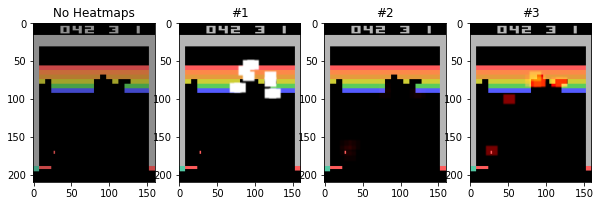

In [12]:
radius = 8
stride = 3

TIMESTEPS = 300

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Can you tell which is best?", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=14, metadata=metadata)

fig, (axes) = plt.subplots(1, 4, gridspec_kw={'width_ratios': [1, 1, 1, 1]}, figsize=(10, 5))
axes[0].set_title("No Heatmaps")
for k in range(1, 4):
    axes[k].set_title(f"#{k}")
frames = [ax.imshow(env.get_images()[0]) for ax in axes]

models = []

rm = RewardModel(env, device)
rm.load_state_dict(th.load(f"../reward-models/breakout_rm_alpha1.5.pt"))
models.append(rm)

rm = RewardModel(env, device)
rm.load_state_dict(th.load(f"../reward-models/breakout_rm_v1.pt"))
models.append(rm)

rm = RewardModel(env, device)
rm.load_state_dict(th.load(f"../reward-models/breakout_rm_alpha0.6.pt"))
models.append(rm)

obs = env.reset()
with writer.saving(fig, "atariocclusion/comparing-noisy-reward-functions.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            env.reset()
        for k in range(3):
            pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(models[k], obs, e, radius=radius))
            screenshot = env.get_images()[0]
            screenshot = screenshot / screenshot.max()
#             max_value = pairs[0][1]
#             max_saliencies.append(max_value)
            for loc, value in pairs:
                r, g, b, a = matplotlib.cm.hot(value)
                region = create_circular_mask(84, 84, center=loc, radius=radius)
                region = skimage.transform.resize(region, (210, 160))
                spot = np.zeros((210, 160, 3))
                spot[:, :, 0] = r * region
                spot[:, :, 1] = g * region
                spot[:, :, 2] = b * region
                spot = spot * a
                screenshot = spot + (1-spot)*screenshot
                screenshot = screenshot / screenshot.max()
            frames[k+1].set_data(screenshot)
        frames[0].set_data(env.get_images()[0])
        writer.grab_frame()
#         plt.subplots_adjust(wspace=0.2)

In [9]:
rm_noise = RewardModel(env, device)

predicted_rewards = []
obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    predicted_rewards.append(rm_noise(obs).item())
    if done:
        break
predicted_rewards = np.array(predicted_rewards)

m, s = predicted_rewards.mean(), predicted_rewards.std()

def shaped(x):
    return (x - m) * 1/s

In [10]:
shaped(predicted_rewards).mean(), shaped(predicted_rewards).std()

(1.8474111129762604e-16, 1.0)

In [11]:
obs = env.reset()
for i in range(100):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if i % 10 == 0:
        print(shaped(rm_noise(obs)))
    if done:
        break

tensor([[-3.7175]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[1.2648]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[1.5971]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[1.8105]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[2.2557]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[2.2804]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[1.0624]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[1.1314]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[0.0841]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[0.5612]], device='cuda:0', grad_fn=<DivBackward0>)


# Save several models with varying amounts of noise

In [12]:
train = RewardData(train=True)
test = RewardData(train=False)

train_loader = th.utils.data.DataLoader(train, batch_size=20, shuffle=True, num_workers=0)
test_loader = th.utils.data.DataLoader(test, batch_size=20, shuffle=False, num_workers=0)

In [13]:
samples, targets = next(iter(train_loader))

In [35]:
loss_fn = th.nn.MSELoss()
alpha = 0.0
rm = RewardModel(env, device)
optimizer = th.optim.Adam(rm.parameters())
for epoch in range(1):
    for samples, targets in islice(train_loader, 500):
        optimizer.zero_grad()
        noise = shaped(rm_noise(samples))
        targets = targets.to(device) + alpha*noise
        batch_loss = loss_fn(rm(samples), targets.to(device))
        batch_loss.backward()
        optimizer.step()
outof = 0
testing_loss = 0
with th.no_grad():
    for samples, target in islice(test_loader, 500):
        testing_loss += loss_fn(rm(samples), targets.to(device))
        outof += len(target)
testing_loss = float(testing_loss / outof)
print("Alpha: {} | Testing Loss: {:.5f}".format(alpha, testing_loss))
# th.save(rm.state_dict(), f"../reward-models/breakout_rm_alpha{alpha}.pt")

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Alpha: 0.0 | Testing Loss: 0.01427


### Okay after regenerating the dataset, it looks like the model can train.

In [39]:
loss_fn = th.nn.MSELoss()
for alpha in [0, 0.1, 0.3, 0.7, 1.5]:
    rm = RewardModel(env, device)
    optimizer = th.optim.Adam(rm.parameters())
    for epoch in range(1):
        for samples, targets in islice(train_loader, 2000):
            optimizer.zero_grad()
            noise = shaped(rm_noise(samples))
            targets = targets.to(device) + alpha*noise
            batch_loss = loss_fn(rm(samples), targets)
            batch_loss.backward()
            optimizer.step()
    outof = 0
    testing_loss = 0
    with th.no_grad():
        for samples, target in islice(test_loader, 2000):
            testing_loss += loss_fn(rm(samples), targets.to(device))
            outof += len(target)
    testing_loss = float(testing_loss / outof)
    print("Alpha: {} | Testing Loss: {:.5f}".format(alpha, testing_loss))
    th.save(rm.state_dict(), f"../reward-models/breakout_rm_alpha{alpha}.pt")

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Alpha: 0 | Testing Loss: 0.01836
Alpha: 0.1 | Testing Loss: 0.03364
Alpha: 0.3 | Testing Loss: 0.27588
Alpha: 0.7 | Testing Loss: 2.20345
Alpha: 1.5 | Testing Loss: 6.96891


## Let's now view the saliency maps

In [41]:
alpha = 0
rm = RewardModel(env, device)
rm.load_state_dict(th.load(f"../reward-models/breakout_rm_alpha{alpha}.pt"))

<All keys matched successfully>

In [45]:
obs = env.reset()
for i in range(100):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
#     if reward[0]:
#         break

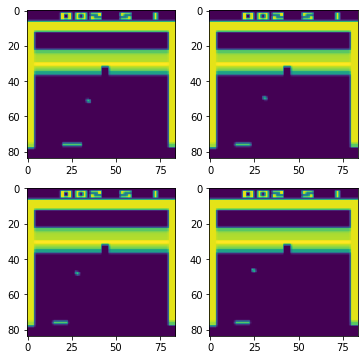

In [46]:
plt.figure(figsize=(6, 6))
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.imshow(obs[0, :, :, k])

In [51]:
random.randint(0, 100)

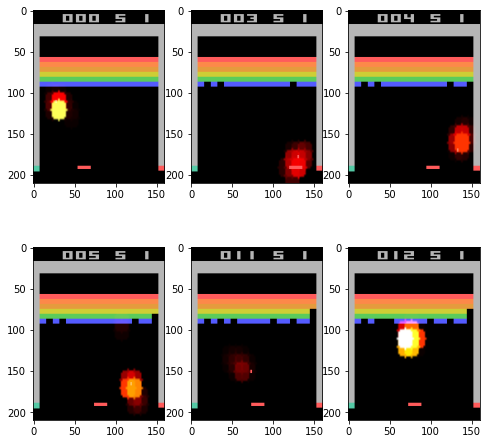

In [53]:
plt.figure(figsize=(8, 8))

radius = 5
stride = 4
k = 0
N = 6

obs = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if random.randint(0, 50) == 0:
        plt.subplot(2, N//2, k+1)
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm, obs, e, radius=radius))
        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()
        # max_value = pairs[0][1]
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            screenshot = spot + (1-spot)*screenshot
            screenshot = screenshot / screenshot.max()
        plt.imshow(screenshot)
        k += 1
    if k == N:
        break

## okay so the baseline (alpha=0) reward looks good

In [54]:
alpha = 1.5
rm = RewardModel(env, device)
rm.load_state_dict(th.load(f"../reward-models/breakout_rm_alpha{alpha}.pt"))

<All keys matched successfully>

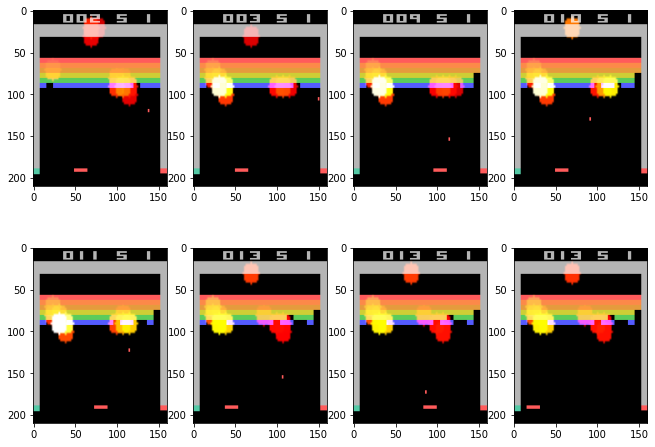

In [57]:
plt.figure(figsize=(11, 8))

radius = 5
stride = 4
k = 0
N = 8

obs = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if random.randint(0, 50) == 0:
        plt.subplot(2, N//2, k+1)
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm, obs, e, radius=radius))
        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()
        # max_value = pairs[0][1]
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            screenshot = spot + (1-spot)*screenshot
            screenshot = screenshot / screenshot.max()
        plt.imshow(screenshot)
        k += 1
    if k == N:
        break

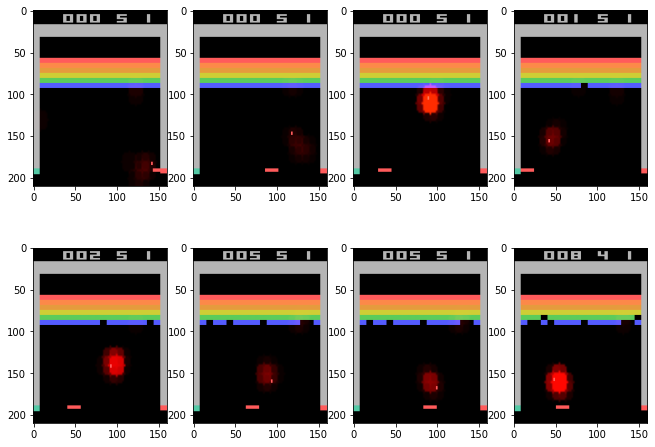

In [58]:
alpha = 0.1
rm = RewardModel(env, device)
rm.load_state_dict(th.load(f"../reward-models/breakout_rm_alpha{alpha}.pt"))

plt.figure(figsize=(11, 8))

radius = 5
stride = 4
k = 0
N = 8

obs = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if random.randint(0, 50) == 0:
        plt.subplot(2, N//2, k+1)
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm, obs, e, radius=radius))
        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()
        # max_value = pairs[0][1]
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            screenshot = spot + (1-spot)*screenshot
            screenshot = screenshot / screenshot.max()
        plt.imshow(screenshot)
        k += 1
    if k == N:
        break

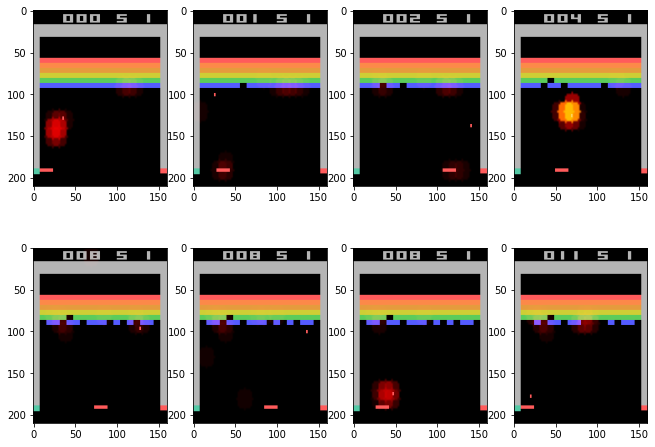

In [59]:
alpha = 0.3
rm = RewardModel(env, device)
rm.load_state_dict(th.load(f"../reward-models/breakout_rm_alpha{alpha}.pt"))

plt.figure(figsize=(11, 8))

radius = 5
stride = 4
k = 0
N = 8

obs = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if random.randint(0, 50) == 0:
        plt.subplot(2, N//2, k+1)
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm, obs, e, radius=radius))
        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()
        # max_value = pairs[0][1]
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            screenshot = spot + (1-spot)*screenshot
            screenshot = screenshot / screenshot.max()
        plt.imshow(screenshot)
        k += 1
    if k == N:
        break

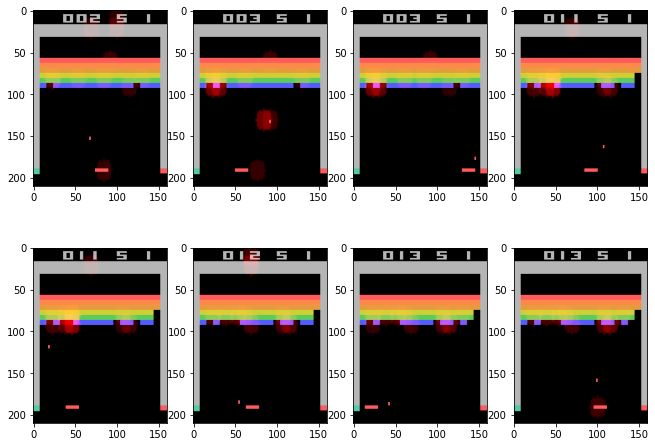

In [60]:
alpha = 0.7
rm = RewardModel(env, device)
rm.load_state_dict(th.load(f"../reward-models/breakout_rm_alpha{alpha}.pt"))

plt.figure(figsize=(11, 8))

radius = 5
stride = 4
k = 0
N = 8

obs = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if random.randint(0, 50) == 0:
        plt.subplot(2, N//2, k+1)
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm, obs, e, radius=radius))
        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()
        # max_value = pairs[0][1]
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            screenshot = spot + (1-spot)*screenshot
            screenshot = screenshot / screenshot.max()
        plt.imshow(screenshot)
        k += 1
    if k == N:
        break

# Time to generate videos now:

In [67]:
matplotlib.use("Agg")
import matplotlib.animation as manimation

In [64]:
alphas = [0, 0.3, 1.5]
random.shuffle(alphas)
alphas

[0, 1.5, 0.3]

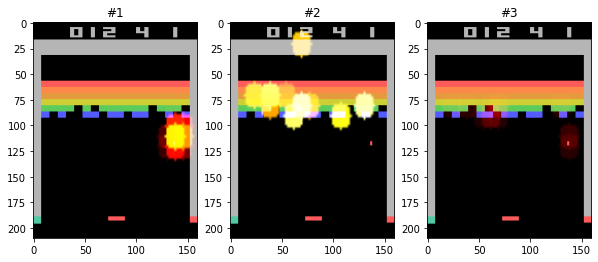

In [68]:
radius = 5
stride = 4

TIMESTEPS = 400

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Can you tell which is best?", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=6, metadata=metadata)

fig, (axes) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]}, figsize=(10, 5))
for k in range(len(alphas)):
    axes[k].set_title(f"#{k+1}")
frames = [ax.imshow(env.get_images()[0]) for ax in axes]

models = []
for k in range(len(alphas)):
    rm = RewardModel(env, device)
    rm.load_state_dict(th.load(f"../reward-models/breakout_rm_alpha{alphas[k]}.pt"))
    models.append(rm)

obs = env.reset()
with writer.saving(fig, "../videos/breakout/comparing_reward_models.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        for k in range(len(alphas)):
            pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(models[k], obs, e, radius=radius))
            screenshot = env.get_images()[0]
            screenshot = screenshot / screenshot.max()
#             max_value = pairs[0][1]
#             max_saliencies.append(max_value)
            for loc, value in pairs:
                r, g, b, a = matplotlib.cm.hot(value)
                region = create_circular_mask(84, 84, center=loc, radius=radius)
                region = skimage.transform.resize(region, (210, 160))
                spot = np.zeros((210, 160, 3))
                spot[:, :, 0] = r * region
                spot[:, :, 1] = g * region
                spot[:, :, 2] = b * region
                spot = spot * a
                screenshot = spot + (1-spot)*screenshot
                screenshot = screenshot / screenshot.max()
            frames[k].set_data(screenshot)
        writer.grab_frame()
#         plt.subplots_adjust(wspace=0.2)

# Let's do 4 now:

In [69]:
alphas = [0, 0.3, 0.7, 1.5]
random.shuffle(alphas)
alphas

[1.5, 0.3, 0.7, 0]

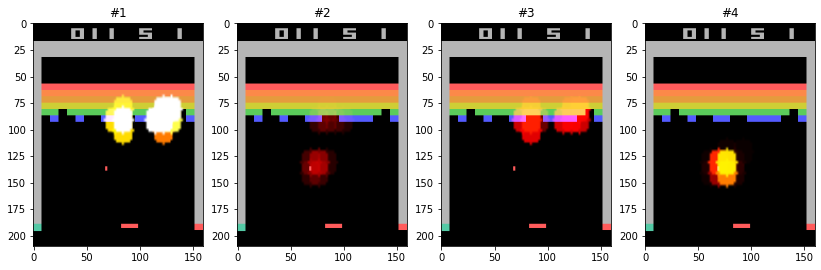

In [71]:
radius = 5
stride = 4

TIMESTEPS = 400

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Can you tell which is best?", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=6, metadata=metadata)

fig, (axes) = plt.subplots(1, 4, gridspec_kw={'width_ratios': [1, 1, 1, 1]}, figsize=(14, 5))
for k in range(len(alphas)):
    axes[k].set_title(f"#{k+1}")
frames = [ax.imshow(env.get_images()[0]) for ax in axes]

models = []
for k in range(len(alphas)):
    rm = RewardModel(env, device)
    rm.load_state_dict(th.load(f"../reward-models/breakout_rm_alpha{alphas[k]}.pt"))
    models.append(rm)

obs = env.reset()
with writer.saving(fig, "../videos/breakout/comparing4_reward_models.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        for k in range(len(alphas)):
            pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(models[k], obs, e, radius=radius))
            screenshot = env.get_images()[0]
            screenshot = screenshot / screenshot.max()
#             max_value = pairs[0][1]
#             max_saliencies.append(max_value)
            for loc, value in pairs:
                r, g, b, a = matplotlib.cm.hot(value)
                region = create_circular_mask(84, 84, center=loc, radius=radius)
                region = skimage.transform.resize(region, (210, 160))
                spot = np.zeros((210, 160, 3))
                spot[:, :, 0] = r * region
                spot[:, :, 1] = g * region
                spot[:, :, 2] = b * region
                spot = spot * a
                screenshot = spot + (1-spot)*screenshot
                screenshot = screenshot / screenshot.max()
            frames[k].set_data(screenshot)
        writer.grab_frame()
#         plt.subplots_adjust(wspace=0.2)

# Let's try training the reward models more, since the saliency disappears close to the blocks.

In [76]:
loss_fn = th.nn.MSELoss()
for alpha in [0, 0.1, 0.3, 0.7, 1.5]:
    rm = RewardModel(env, device)
    optimizer = th.optim.Adam(rm.parameters())
    for epoch in range(3):
        for samples, targets in train_loader:
            optimizer.zero_grad()
            noise = shaped(rm_noise(samples))
            targets = targets.to(device) + alpha*noise
            batch_loss = loss_fn(rm(samples), targets)
            batch_loss.backward()
            optimizer.step()
    outof = 0
    testing_loss = 0
    with th.no_grad():
        for samples, target in test_loader:
            testing_loss += loss_fn(rm(samples), targets.to(device))
            outof += len(target)
    testing_loss = float(testing_loss / outof)
    print("Alpha: {} | Testing Loss: {:.5f}".format(alpha, testing_loss))
    th.save(rm.state_dict(), f"../reward-models/breakout_rm_moretraining_alpha{alpha}.pt")

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Alpha: 0 | Testing Loss: 0.02032
Alpha: 0.1 | Testing Loss: 0.04039
Alpha: 0.3 | Testing Loss: 0.33325
Alpha: 0.7 | Testing Loss: 1.45024
Alpha: 1.5 | Testing Loss: 8.01371


In [77]:
alpha = 0
rm = RewardModel(env, device)
rm.load_state_dict(th.load(f"../reward-models/breakout_rm_moretraining_alpha{alphas[k]}.pt"))

<All keys matched successfully>

In [80]:
obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if reward[0]:
        break

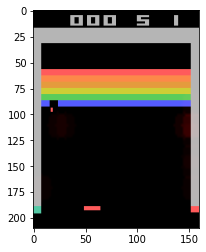

In [81]:
radius = 5
stride = 4

pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm, obs, e, radius=radius))
screenshot = env.get_images()[0]
screenshot = screenshot / screenshot.max()
# max_value = pairs[0][1]
for loc, value in pairs:
    r, g, b, a = matplotlib.cm.hot(value)
    region = create_circular_mask(84, 84, center=loc, radius=radius)
    region = skimage.transform.resize(region, (210, 160))
    spot = np.zeros((210, 160, 3))
    spot[:, :, 0] = r * region
    spot[:, :, 1] = g * region
    spot[:, :, 2] = b * region
    spot = spot * a
    screenshot = spot + (1-spot)*screenshot
    screenshot = screenshot / screenshot.max()
plt.imshow(screenshot)

In [82]:
alphas = [1.5, 0.3, 0.7, 0]

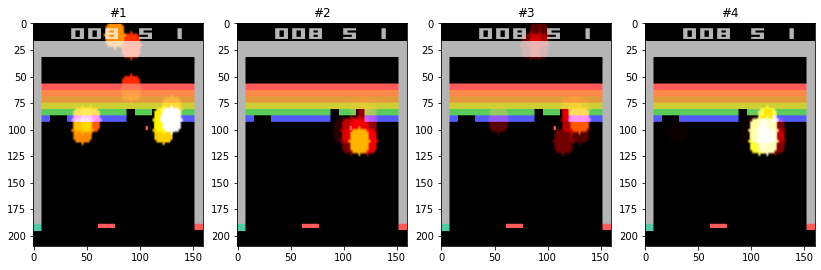

In [85]:
radius = 5
stride = 4

TIMESTEPS = 300

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Can you tell which is best?", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=6, metadata=metadata)

fig, (axes) = plt.subplots(1, 4, gridspec_kw={'width_ratios': [1, 1, 1, 1]}, figsize=(14, 5))
for k in range(len(alphas)):
    axes[k].set_title(f"#{k+1}")
frames = [ax.imshow(env.get_images()[0]) for ax in axes]

models = []
for k in range(len(alphas)):
    rm = RewardModel(env, device)
    rm.load_state_dict(th.load(f"../reward-models/breakout_rm_moretraining_alpha{alphas[k]}.pt"))
    models.append(rm)

obs = env.reset()
with writer.saving(fig, "../videos/breakout/comparing4_reward_models_moretraining.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        for k in range(len(alphas)):
            pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(models[k], obs, e, radius=radius))
            screenshot = env.get_images()[0]
            screenshot = screenshot / screenshot.max()
#             max_value = pairs[0][1]
#             max_saliencies.append(max_value)
            for loc, value in pairs:
                r, g, b, a = matplotlib.cm.hot(value)
                region = create_circular_mask(84, 84, center=loc, radius=radius)
                region = skimage.transform.resize(region, (210, 160))
                spot = np.zeros((210, 160, 3))
                spot[:, :, 0] = r * region
                spot[:, :, 1] = g * region
                spot[:, :, 2] = b * region
                spot = spot * a
                screenshot = spot + (1-spot)*screenshot
                screenshot = screenshot / screenshot.max()
            frames[k].set_data(screenshot)
        writer.grab_frame()
#         plt.subplots_adjust(wspace=0.2)